In [ ]:
!pip install opendatasets --upgrade -q

In [ ]:
import torch
import tarfile
import numpy as np
import os
import time
import random
import copy

import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision import models

from torch import optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import opendatasets as od

In [ ]:
"""
CIFAR100
100 classes containing 600 images each. 
There are 500 training images and 100 testing images per class. 
The 100 classes in the CIFAR-100 are grouped into 20 superclasses.
"""

'\nCIFAR100\n100 classes containing 600 images each. \nThere are 500 training images and 100 testing images per class. \nThe 100 classes in the CIFAR-100 are grouped into 20 superclasses.\n'

In [ ]:
#_______________________________Preparing the data__________________________
batch_size = 400
num_workers = 2

In [ ]:
%rm -rf cifar-100-images

In [ ]:
dataset_url = 'https://www.kaggle.com/minbavel/cifar-100-images'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dukich
Your Kaggle Key: ··········


100%|██████████| 140M/140M [00:04<00:00, 35.9MB/s]


In [ ]:
data_dir = './cifar-100-images/CIFAR100/TRAIN'
print("Number of categories in CIFAR100 are {}".format(len(os.listdir(data_dir))))
# As we have around 50000 images across 100 categories, lets keep 20% images, i.e 10000 images to validation
# this creates all required folders, such as Val and their subfolders
val_path = './cifar-100-images/CIFAR100/VAL'
source_dir = './cifar-100-images/CIFAR100/TRAIN'

os.mkdir(val_path)

for i in sorted(os.listdir(source_dir)):
  path = val_path+'/'+i
  os.mkdir(path)

Number of categories in CIFAR100 are 100


In [ ]:
for folder in sorted(os.listdir(source_dir)):
    dest_path = val_path+'/'+folder
    source_path = source_dir+'/'+folder

    source_files = os.listdir(source_path)
    randint = sorted(random.sample(range(500), 100))
    # print("Random Integers \n",randint)
    for file in randint:
        source_file_name = source_path+'/'+source_files[file]
        dest_file_name = dest_path+'/'+source_files[file]
        os.rename(source_file_name,dest_file_name)

In [ ]:
print("Number of files in Train folder are {}".
format(sum([len(os.listdir(data_dir+'/'+x)) for x in os.listdir(data_dir)])))
print("Number of files in Validation folder are {}".
format(sum([len(os.listdir(val_path+'/'+x)) for x in os.listdir(val_path)])))

Number of files in Train folder are 40000
Number of files in Validation folder are 10000


In [ ]:
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4866, 0.4409], [0.2673, 0.2564, 0.2762])
    ]),
    'VAL': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4866, 0.4409], [0.2673, 0.2564, 0.2762])
    ]),
}

In [ ]:
data_dir = './cifar-100-images/CIFAR100/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['TRAIN', 'VAL']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['TRAIN', 'VAL']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'VAL']}
class_names = image_datasets['TRAIN'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


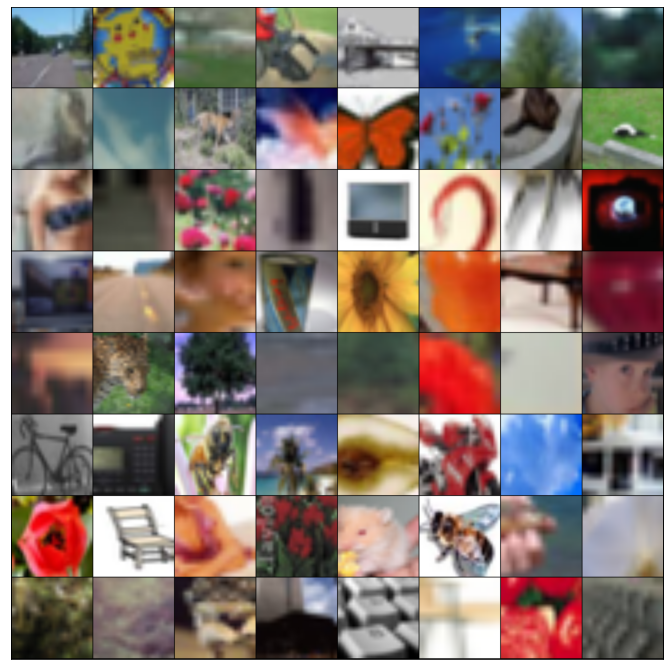

In [ ]:
#___________________writing helper function to display a sample of images.________________________________
inputs, classes = next(iter(dataloaders['TRAIN']))


def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means



fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
denorm_images = denormalize(inputs, [0.5071, 0.4866, 0.4409],[0.2673, 0.2564, 0.2762])
ax.imshow(torchvision.utils.make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))

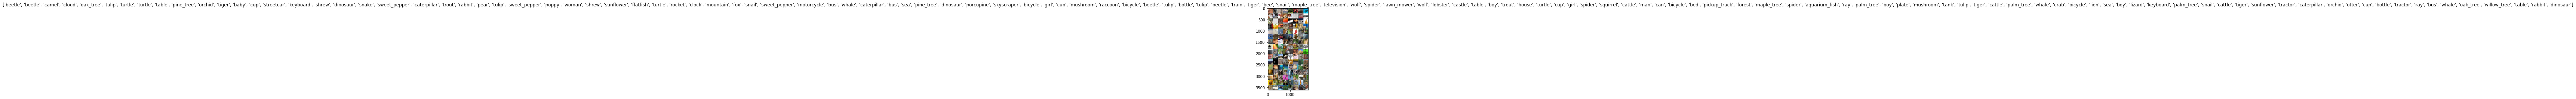

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4866, 0.4409])
    std = np.array([0.2673, 0.2564, 0.2762])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['TRAIN']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=8)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#__________________Train using GPU__________________
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
save_train_loss = []
save_val_loss = []
save_train_acc = []
save_val_acc = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN', 'VAL']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TRAIN':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'VAL' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['VAL']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
models.resnet50(pretrained=True).fc.in_features

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2048

In [ ]:
weight_decay = 1e-4
max_lr = 0.005
epochs = 25

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = torch.optim.Adam(model_conv.fc.parameters(), max_lr, weight_decay = weight_decay)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_conv, max_lr, epochs=epochs, 
                                                       steps_per_epoch=len(dataloaders['TRAIN']))

In [ ]:
 model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
TRAIN Loss: 3.9286 Acc: 0.1691
VAL Loss: 3.1266 Acc: 0.3629

Epoch 1/24
----------
TRAIN Loss: 3.1763 Acc: 0.3002
VAL Loss: 2.5795 Acc: 0.4282

Epoch 2/24
----------
TRAIN Loss: 2.8847 Acc: 0.3316
VAL Loss: 2.2942 Acc: 0.4640

Epoch 3/24
----------
TRAIN Loss: 2.7274 Acc: 0.3535
VAL Loss: 2.1377 Acc: 0.4869

Epoch 4/24
----------
TRAIN Loss: 2.6333 Acc: 0.3648
VAL Loss: 2.0479 Acc: 0.4972

Epoch 5/24
----------
TRAIN Loss: 2.5653 Acc: 0.3742
VAL Loss: 1.9769 Acc: 0.5034

Epoch 6/24
----------
TRAIN Loss: 2.5195 Acc: 0.3816
VAL Loss: 1.9240 Acc: 0.5113

Epoch 7/24
----------
TRAIN Loss: 2.4895 Acc: 0.3853
VAL Loss: 1.8704 Acc: 0.5171

Epoch 8/24
----------
TRAIN Loss: 2.4530 Acc: 0.3927
VAL Loss: 1.8392 Acc: 0.5212

Epoch 9/24
----------
TRAIN Loss: 2.4298 Acc: 0.4002
VAL Loss: 1.8170 Acc: 0.5235

Epoch 10/24
----------
TRAIN Loss: 2.4004 Acc: 0.3996
VAL Loss: 1.7893 Acc: 0.5300

Epoch 11/24
----------
TRAIN Loss: 2.3809 Acc: 0.4042
VAL Loss: 1.7796 Acc: 0.5335

Ep